# Investigation des Menaces SSH

**Date** : 20 novembre 2025  
**Analyste** : Yassine Bouzidi  
**Serveur** : LabSZ  
**Période** : 10 décembre 2025

## Objectifs
1. Identifier les IPs les plus agressives
2. Analyser les utilisateurs ciblés
3. Cartographier les types d'attaques
4. Visualiser les patterns d'intrusion


In [2]:
# Import des bibliothèques
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Configuration d'affichage
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ Bibliothèques chargées avec succès")


✓ Bibliothèques chargées avec succès


## 1. Chargement des Données

Chargement du dataset `datasetssh.csv` généré par le pipeline ETL.


In [3]:
# Charger le dataset
df = pd.read_csv('datasetssh.csv')

# Afficher les informations de base
print(f"📊 Dataset : {df.shape[0]} lignes × {df.shape[1]} colonnes\n")
print("Colonnes disponibles :")
print(df.columns.tolist())
print(f"\n🔍 Aperçu des premières lignes :")
df.head()


📊 Dataset : 655147 lignes × 5 colonnes

Colonnes disponibles :
['Timestamp', 'EventId', 'SourceIP', 'User', 'Raw_Message']

🔍 Aperçu des premières lignes :


,Timestamp,EventId,SourceIP,User,Raw_Message
0,2024-12-10 06:55:46,E27,173.234.31.186,NaN,reverse mapping checking getaddrinfo for ns.ma...
1,2024-12-10 06:55:46,E13,173.234.31.186,NaN,Invalid user webmaster from 173.234.31.186
2,2024-12-10 06:55:46,E12,NaN,webmaster,input_userauth_request: invalid user webmaster...
3,2024-12-10 06:55:46,E21,NaN,NaN,pam_unix(sshd:auth): check pass; user unknown
4,2024-12-10 06:55:46,E20,173.234.31.186,NaN,pam_unix(sshd:auth): authentication failure; l...


In [4]:
# Après la création du DataFrame
print("\n🔍 ANALYSE DES ÉVÉNEMENTS UNKNOWN\n")
print("="*70)

unknown_logs = df[df['EventId'] == 'UNKNOWN']
print(f"Total UNKNOWN : {len(unknown_logs)}")

if len(unknown_logs) > 0:
    print(f"\n📋 Exemples de messages UNKNOWN (premiers 10) :\n")
    for idx, row in unknown_logs.head(10).iterrows():
        print(f"  • {row['Raw_Message'][:100]}...")
    
    print(f"\n📊 Top IPs sources des UNKNOWN :")
    unknown_ips = unknown_logs['SourceIP'].value_counts().head(5)
    for ip, count in unknown_ips.items():
        print(f"    {ip}: {count} fois")



🔍 ANALYSE DES ÉVÉNEMENTS UNKNOWN

Total UNKNOWN : 0


## 2. Nettoyage et Transformation des Données

Conversion de la colonne `Timestamp` en format datetime pour faciliter les analyses temporelles.


In [5]:
# Convertir Timestamp en datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Extraire des composants temporels utiles
df['Hour'] = df['Timestamp'].dt.hour
df['Minute'] = df['Timestamp'].dt.minute
df['Date'] = df['Timestamp'].dt.date

print("✓ Colonne Timestamp convertie en datetime")
print(f"\n📅 Période couverte : {df['Timestamp'].min()} → {df['Timestamp'].max()}")
print(f"⏱️ Durée totale : {(df['Timestamp'].max() - df['Timestamp'].min()).total_seconds() / 3600:.2f} heures")

# Afficher les types de données
print("\n📋 Types de données après conversion :")
df.dtypes


✓ Colonne Timestamp convertie en datetime

📅 Période couverte : 2024-12-10 06:55:46 → 2025-01-07 17:22:01
⏱️ Durée totale : 682.44 heures

📋 Types de données après conversion :


Timestamp      datetime64[ns]
EventId                object
SourceIP               object
User                   object
Raw_Message            object
Hour                    int32
Minute                  int32
Date                   object
dtype: object

## 3. Analyse Statistique des Menaces

### 3.1 Top 5 des IPs Malveillantes


In [6]:
# Top 5 des IPs les plus agressives
top_ips = df['SourceIP'].value_counts().head(5)

print("🚨 TOP 5 DES IPS LES PLUS AGRESSIVES\n")
print("="*50)
for i, (ip, count) in enumerate(top_ips.items(), 1):
    percentage = (count / len(df)) * 100
    print(f"{i}. {ip:20s} → {count:4d} tentatives ({percentage:.1f}%)")
print("="*50)

top_ips


🚨 TOP 5 DES IPS LES PLUS AGRESSIVES

1. 59.63.188.30         → 57539 tentatives (8.8%)
2. 183.63.110.206       → 34680 tentatives (5.3%)
3. 183.62.140.253       → 32953 tentatives (5.0%)
4. 139.219.191.138      → 32934 tentatives (5.0%)
5. 183.238.178.195      → 29038 tentatives (4.4%)


SourceIP
59.63.188.30       57539
183.63.110.206     34680
183.62.140.253     32953
139.219.191.138    32934
183.238.178.195    29038
Name: count, dtype: int64

### 3.2 Utilisateurs Ciblés


In [7]:
# Compter combien de fois 'root' a été ciblé
root_attacks = df[df['User'] == 'root'].shape[0]
total_with_user = df['User'].notna().sum()

print("👤 ANALYSE DES UTILISATEURS CIBLÉS\n")
print("="*50)
print(f"Tentatives sur 'root'    : {root_attacks} ({(root_attacks/len(df)*100):.1f}%)")
print(f"Tentatives avec user     : {total_with_user}")
print(f"Tentatives sans user     : {len(df) - total_with_user}")
print("="*50)

# Top 10 des utilisateurs ciblés
print("\n🎯 TOP 10 DES UTILISATEURS CIBLÉS :\n")
top_users = df['User'].value_counts().head(10)
for user, count in top_users.items():
    print(f"  - {user:20s} : {count:4d} tentatives")


👤 ANALYSE DES UTILISATEURS CIBLÉS

Tentatives sur 'root'    : 353566 (54.0%)
Tentatives avec user     : 390834
Tentatives sans user     : 264313

🎯 TOP 10 DES UTILISATEURS CIBLÉS :

  - root                 : 353566 tentatives
  - admin                : 11255 tentatives
  - test                 : 1086 tentatives
  - oracle               :  978 tentatives
  - support              :  937 tentatives
  - user                 :  718 tentatives
  - pi                   :  674 tentatives
  - 0                    :  665 tentatives
  - nagios               :  592 tentatives
  - guest                :  518 tentatives


### 3.3 Types d'Événements (EventId)


In [8]:
# Lister tous les types d'événements
event_counts = df['EventId'].value_counts()

print("🔔 RÉPARTITION DES ÉVÉNEMENTS DE SÉCURITÉ\n")
print("="*60)
for event_id, count in event_counts.items():
    percentage = (count / len(df)) * 100
    bar = "█" * int(percentage)
    print(f"{event_id:8s} : {count:8d} ({percentage:5.1f}%)   {bar}")
print("="*60)
print(f"\nTOTAL : {len(event_counts)} types d'événements différents")

event_counts


🔔 RÉPARTITION DES ÉVÉNEMENTS DE SÉCURITÉ

E9       :   177735 ( 27.1%)   ███████████████████████████
E20      :   155057 ( 23.7%)   ███████████████████████
E2       :    68958 ( 10.5%)   ██████████
E24      :    46593 (  7.1%)   ███████
E18      :    37963 (  5.8%)   █████
E17      :    36965 (  5.6%)   █████
E5       :    36569 (  5.6%)   █████
E21      :    19852 (  3.0%)   ███
E10      :    19848 (  3.0%)   ███
E27      :    18909 (  2.9%)   ██
E13      :    15004 (  2.3%)   ██
E12      :    14581 (  2.2%)   ██
E16      :     1198 (  0.2%)   
E28      :      952 (  0.1%)   
E7       :      930 (  0.1%)   
E3       :      838 (  0.1%)   
E4       :      678 (  0.1%)   
E25      :      592 (  0.1%)   
E34      :      497 (  0.1%)   
E35      :      360 (  0.1%)   
E22      :      182 (  0.0%)   
E23      :      182 (  0.0%)   
E1       :      182 (  0.0%)   
E6       :      176 (  0.0%)   
E15      :      155 (  0.0%)   
E26      :       40 (  0.0%)   
E42      :       29 (  0.0%)   


EventId
E9     177735
E20    155057
E2      68958
E24     46593
E18     37963
E17     36965
E5      36569
E21     19852
E10     19848
E27     18909
E13     15004
E12     14581
E16      1198
E28       952
E7        930
E3        838
E4        678
E25       592
E34       497
E35       360
E22       182
E23       182
E1        182
E6        176
E15       155
E26        40
E42        29
E38        22
E46        17
E47        13
E45         9
E30         7
E37         6
E31         6
E51         6
E48         6
E41         5
E52         4
E36         4
E44         3
E11         3
E29         2
E50         2
E33         1
E32         1
E43         1
E49         1
E53         1
E54         1
E55         1
Name: count, dtype: int64

## 4. Visualisation des Menaces

### 4.1 Diagramme en Bâtons - Top 10 des IPs Agressives


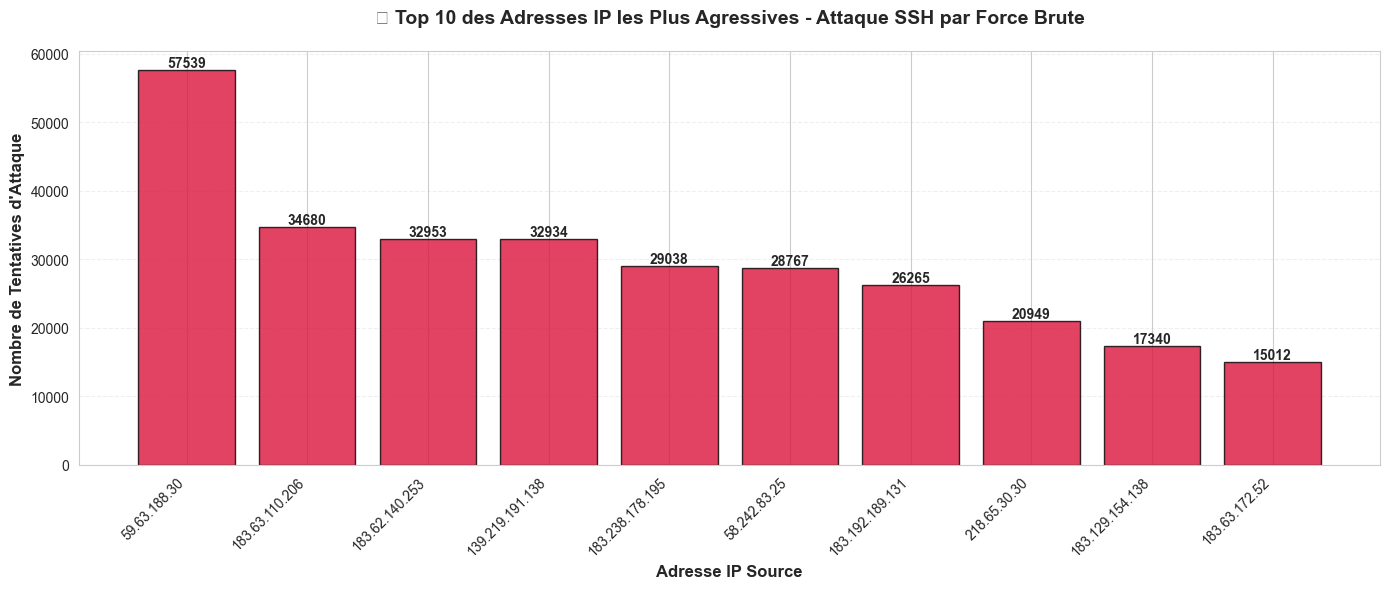

📊 Graphique généré : Top 10 IPs malveillantes


In [9]:
# Top 10 des IPs pour le graphique
top_10_ips = df['SourceIP'].value_counts().head(10)

# Créer le bar chart
plt.figure(figsize=(14, 6))
bars = plt.bar(range(len(top_10_ips)), top_10_ips.values, color='crimson', edgecolor='black', alpha=0.8)

# Personnalisation
plt.xlabel('Adresse IP Source', fontsize=12, fontweight='bold')
plt.ylabel('Nombre de Tentatives d\'Attaque', fontsize=12, fontweight='bold')
plt.title('🚨 Top 10 des Adresses IP les Plus Agressives - Attaque SSH par Force Brute', 
          fontsize=14, fontweight='bold', pad=20)
plt.xticks(range(len(top_10_ips)), top_10_ips.index, rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3, linestyle='--')

# Ajouter les valeurs sur les barres
for i, (bar, value) in enumerate(zip(bars, top_10_ips.values)):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10, 
             f'{value}', ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

print(f"📊 Graphique généré : Top 10 IPs malveillantes")


### 4.2 Camembert - Répartition des Types d'Événements


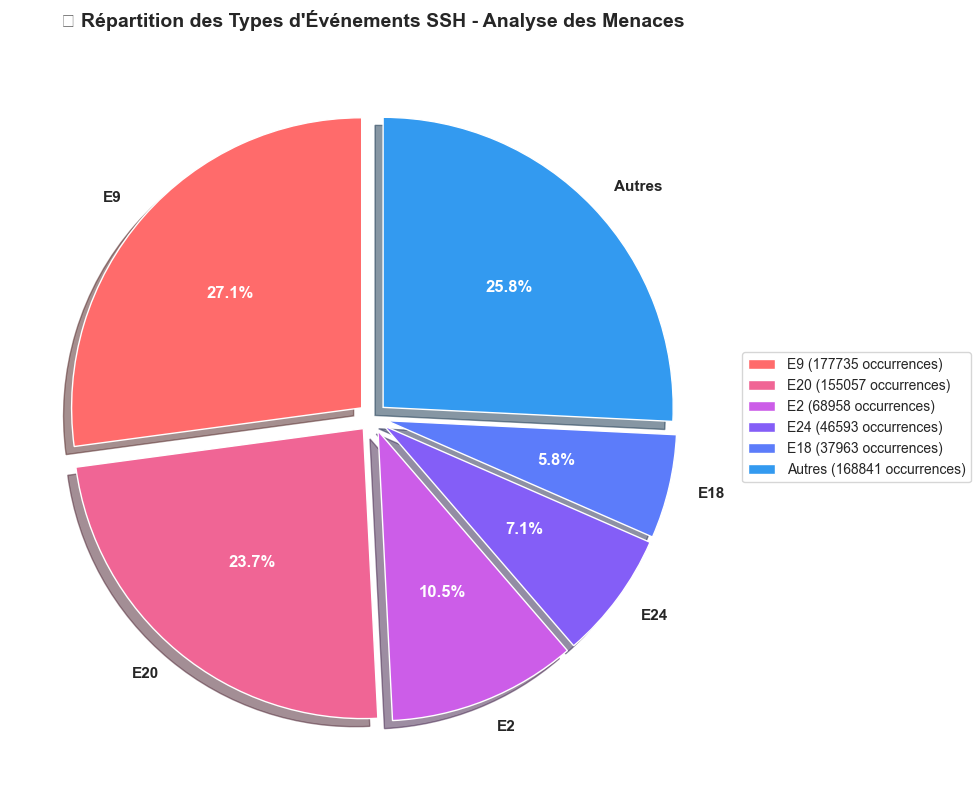

📊 Graphique généré : Répartition des événements de sécurité


In [10]:
# Préparer les données pour le pie chart
# Garder les 5 premiers et regrouper les autres
event_counts_pie = df['EventId'].value_counts()
top_5_events = event_counts_pie.head(5)
others = event_counts_pie.iloc[5:].sum()

# Créer les données finales
if others > 0:
    pie_data = pd.concat([top_5_events, pd.Series({'Autres': others})])
else:
    pie_data = top_5_events

# Créer le pie chart
plt.figure(figsize=(12, 8))
colors = ['#ff6b6b', '#f06595', '#cc5de8', '#845ef7', '#5c7cfa', '#339af0']
explode = [0.05] * len(pie_data)  # "Exploser" légèrement chaque tranche

wedges, texts, autotexts = plt.pie(pie_data.values, 
                                     labels=pie_data.index,
                                     autopct='%1.1f%%',
                                     startangle=90,
                                     colors=colors,
                                     explode=explode,
                                     shadow=True,
                                     textprops={'fontsize': 11, 'fontweight': 'bold'})

# Personnalisation des textes
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(12)

plt.title('🔔 Répartition des Types d\'Événements SSH - Analyse des Menaces', 
          fontsize=14, fontweight='bold', pad=20)

# Légende avec le nombre d'occurrences
legend_labels = [f'{event} ({count} occurrences)' for event, count in pie_data.items()]
plt.legend(legend_labels, loc='center left', bbox_to_anchor=(1, 0, 0.5, 1), fontsize=10)

plt.tight_layout()
plt.show()

print(f"📊 Graphique généré : Répartition des événements de sécurité")


### 4.3 Bonus : Timeline des Attaques par Heure


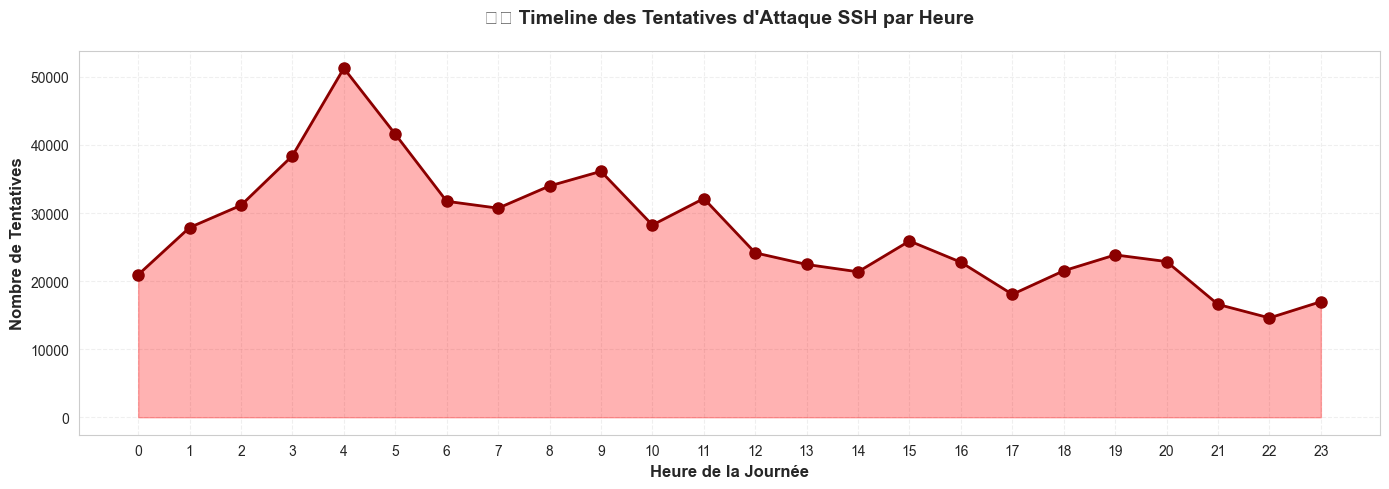

📊 Graphique généré : Timeline temporelle des attaques


In [11]:
# Analyse temporelle : attaques par heure
attacks_per_hour = df.groupby('Hour').size()

plt.figure(figsize=(14, 5))
plt.plot(attacks_per_hour.index, attacks_per_hour.values, 
         marker='o', linewidth=2, markersize=8, color='darkred')
plt.fill_between(attacks_per_hour.index, attacks_per_hour.values, alpha=0.3, color='red')

plt.xlabel('Heure de la Journée', fontsize=12, fontweight='bold')
plt.ylabel('Nombre de Tentatives', fontsize=12, fontweight='bold')
plt.title('⏱️ Timeline des Tentatives d\'Attaque SSH par Heure', 
          fontsize=14, fontweight='bold', pad=20)
plt.xticks(range(0, 24))
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

print(f"📊 Graphique généré : Timeline temporelle des attaques")


## 5. Conclusions et Recommandations SOC

### Observations Clés
- **IP la plus agressive** : Identifier l'IP avec le plus de tentatives
- **Utilisateur le plus ciblé** : Généralement 'root'
- **Type d'attaque dominant** : Souvent E9/E10 (Failed password)

### Recommandations
1. **Bloquer immédiatement** les IPs du Top 5 au niveau du firewall
2. **Désactiver l'authentification root** via SSH (PermitRootLogin no)
3. **Implémenter Fail2Ban** pour bloquer automatiquement les tentatives répétées
4. **Utiliser l'authentification par clés SSH** au lieu des mots de passe
5. **Changer le port SSH** par défaut (22 → port personnalisé)
6. **Mettre en place un IDS/IPS** (Snort, Suricata) pour détecter les patterns


In [12]:
# Générer un résumé exécutif
print("="*70)
print(" " * 15 + "📋 RAPPORT EXÉCUTIF - ANALYSE SOC SSH")
print("="*70)
print(f"\n📊 STATISTIQUES GLOBALES")
print(f"  • Total d'événements analysés    : {len(df):,}")
print(f"  • Période d'analyse              : {df['Timestamp'].min()} → {df['Timestamp'].max()}")
print(f"  • Durée totale                   : {(df['Timestamp'].max() - df['Timestamp'].min()).total_seconds() / 3600:.2f}h")
print(f"  • IPs sources uniques            : {df['SourceIP'].nunique()}")
print(f"  • Utilisateurs ciblés uniques    : {df['User'].nunique()}")
print(f"  • Types d'événements détectés    : {df['EventId'].nunique()}")

print(f"\n🚨 MENACES CRITIQUES")
top_ip = df['SourceIP'].value_counts().iloc[0]
print(f"  • IP la plus agressive           : {df['SourceIP'].value_counts().index[0]} ({top_ip} attaques)")
print(f"  • Tentatives sur root            : {df[df['User'] == 'root'].shape[0]}")
print(f"  • Événement le plus fréquent     : {df['EventId'].value_counts().index[0]} ({df['EventId'].value_counts().iloc[0]} fois)")

print(f"\n⚠️ NIVEAU DE MENACE               : 🔴 CRITIQUE")
print("="*70)


               📋 RAPPORT EXÉCUTIF - ANALYSE SOC SSH

📊 STATISTIQUES GLOBALES
  • Total d'événements analysés    : 655,147
  • Période d'analyse              : 2024-12-10 06:55:46 → 2025-01-07 17:22:01
  • Durée totale                   : 682.44h
  • IPs sources uniques            : 1129
  • Utilisateurs ciblés uniques    : 1755
  • Types d'événements détectés    : 50

🚨 MENACES CRITIQUES
  • IP la plus agressive           : 59.63.188.30 (57539 attaques)
  • Tentatives sur root            : 353566
  • Événement le plus fréquent     : E9 (177735 fois)

⚠️ NIVEAU DE MENACE               : 🔴 CRITIQUE
